# Mount Google Drive and Access Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import os

# Change this path if needed - Please verify this path in your Google Drive
vt_path = "/content/drive/MyDrive/VT"

# List contents
os.listdir(vt_path)

['Fingerprint_Autoencoder.ipynb',
 'Plant_Images_Denoising.ipynb',
 'PlantVillage_Noisy_Dataset',
 'Fingerprints']

In [7]:
dataset_path = os.path.join(vt_path, "PlantVillage_Noisy_Dataset")
os.listdir(dataset_path)

['PlantVillage']

In [8]:
plant_village_path = os.path.join(dataset_path, "PlantVillage")
os.listdir(plant_village_path)[:10]  # Show the first 10 items


['Pure_Dataset', 'Noisy_Dataset']

# Load, Resize, and Normalize the Images

In [10]:
print("Pure_Dataset files:", os.listdir(pure_path)[:5])
print("Noisy_Dataset files:", os.listdir(noisy_path)[:5])


Pure_Dataset files: ['Train_Data', 'Test_Data']
Noisy_Dataset files: ['Test_Data', 'Train_Data']


In [13]:
def load_images_recursive(folder_path, img_size=(64, 64)):
    images = []
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                    file_path = os.path.join(subfolder_path, filename)
                    img = cv2.imread(file_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        img = img.astype(np.float32) / 255.0
                        images.append(img)
    return np.array(images)

# Define subfolder paths
pure_train = os.path.join(pure_path, "Train_Data")
pure_test = os.path.join(pure_path, "Test_Data")
noisy_train = os.path.join(noisy_path, "Train_Data")
noisy_test = os.path.join(noisy_path, "Test_Data")

# Load all images
X_train_clean = load_images_recursive(pure_train)
X_test_clean = load_images_recursive(pure_test)
X_train_noisy = load_images_recursive(noisy_train)
X_test_noisy = load_images_recursive(noisy_test)

# Verify
print("Train clean:", X_train_clean.shape)
print("Train noisy:", X_train_noisy.shape)
print("Test clean:", X_test_clean.shape)
print("Test noisy:", X_test_noisy.shape)



Train clean: (3007, 64, 64, 3)
Train noisy: (3007, 64, 64, 3)
Test clean: (1613, 64, 64, 3)
Test noisy: (1613, 64, 64, 3)


# Autoencoders

## 1. MLP-Based Autoencoder

In [14]:
from tensorflow.keras import layers, models

input_shape = (64, 64, 3)
flatten_dim = 64 * 64 * 3

# MLP Autoencoder
def build_mlp_autoencoder():
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(flatten_dim, activation='sigmoid'),
        layers.Reshape(input_shape)
    ])
    return model

mlp_autoencoder = build_mlp_autoencoder()
mlp_autoencoder.compile(optimizer='adam', loss='mse')
mlp_autoencoder.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    12,583,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12288)          │    12,595,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,229,248 (100.06 MB)

 Trainable params: 26,229,248 (100.06 MB)

 Non-trainable params: 0 (0.00 B)

## 2. Train the Autoencoder

In [15]:
history = mlp_autoencoder.fit(
    X_train_noisy, X_train_clean,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_noisy, X_test_clean)
)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 678ms/step - loss: 0.0336 - val_loss: 0.0303
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 659ms/step - loss: 0.0316 - val_loss: 0.0307
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 64s 688ms/step - loss: 0.0321 - val_loss: 0.0303
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 79s 658ms/step - loss: 0.0322 - val_loss: 0.0306
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 663ms/step - loss: 0.0317 - val_loss: 0.0305
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 64s 681ms/step - loss: 0.0317 - val_loss: 0.0307
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 79s 653ms/step - loss: 0.0313 - val_loss: 0.0304
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 83s 661ms/step - loss: 0.0314 - val_loss: 0.0304
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 661ms/step - loss: 0.0314 - val_loss: 0.0309
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 83s 676ms/step - loss: 0.0310 - val_loss: 0.0309
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 79s 649ms/step - loss: 0.0308 - val_loss: 0.0309
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 87

## 3. Visualize Results

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step


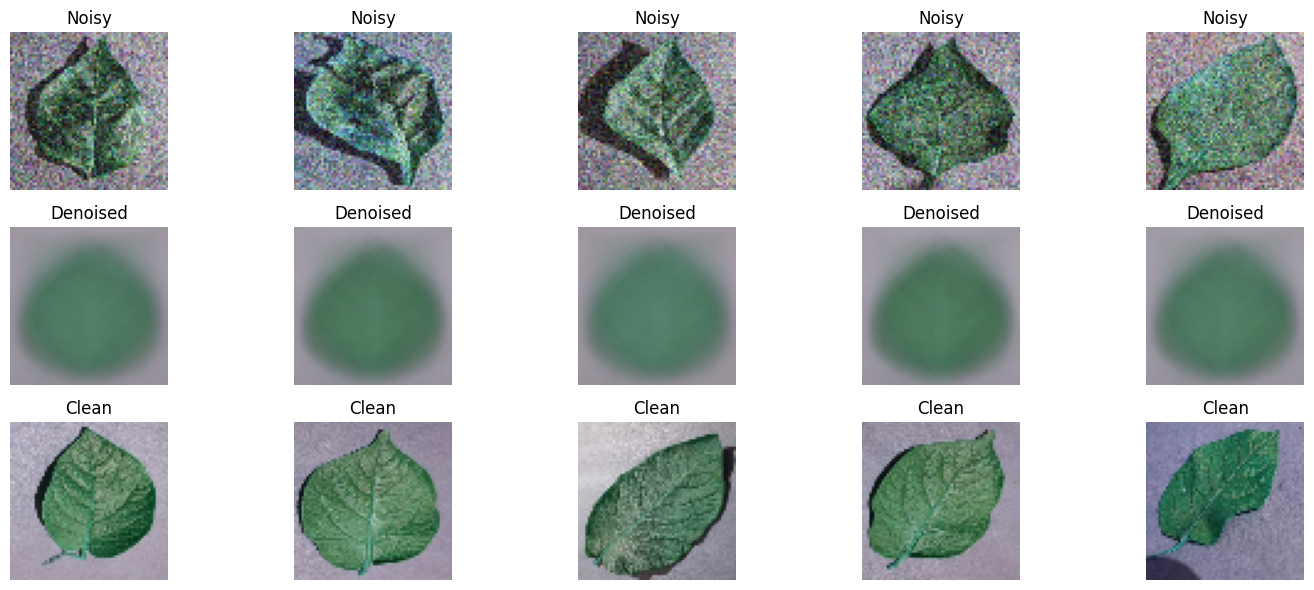

In [16]:
import matplotlib.pyplot as plt

# Predict on test data
denoised = mlp_autoencoder.predict(X_test_noisy)

# Visualize first 5 samples
def show_comparison(noisy, denoised, clean, n=5):
    plt.figure(figsize=(15, 6))
    for i in range(n):
        # Noisy
        plt.subplot(3, n, i+1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis("off")

        # Denoised
        plt.subplot(3, n, i+1+n)
        plt.imshow(denoised[i])
        plt.title("Denoised")
        plt.axis("off")

        # Ground Truth
        plt.subplot(3, n, i+1+2*n)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_comparison(X_test_noisy, denoised, X_test_clean)


## 🧠 Evaluation: MLP Autoencoder Denoising Results

### ✅ What’s Working:
- The model successfully learns the **overall color and shape** of leaves.
- It manages to reduce **heavy grainy noise**, especially in central image regions.

### ⚠️ What’s Not Working Well:
- The **denoised images appear blurry** and lack detail.
- **Fine textures, edges, and disease patterns** are not recovered accurately.
- The model fails to preserve important structural details required for fine-grained leaf classification.

---

### 💡 Why This Happens:
- MLP-based autoencoders **flatten the image into 1D**, which destroys spatial relationships between pixels.
- These models are not well-suited for image tasks where **spatial structure is critical**.
- Unlike CNNs, MLPs cannot effectively capture **local visual patterns** like edges and textures.

---

🔜 **Next Step:** Implement a **Convolutional Autoencoder** to better preserve spatial features and improve denoising performance.


## 1. CNN Autoencoder Definition

In [17]:
from tensorflow.keras import layers, models

def build_cnn_autoencoder():
    input_img = layers.Input(shape=(64, 64, 3))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return models.Model(input_img, decoded)

cnn_autoencoder = build_cnn_autoencoder()
cnn_autoencoder.compile(optimizer='adam', loss='mse')
cnn_autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,347 (52.14 KB)

 Trainable params: 13,347 (52.14 KB)

 Non-trainable params: 0 (0.00 B)

## 2. Train the CNN Autoencoder

In [18]:
history_cnn = cnn_autoencoder.fit(
    X_train_noisy, X_train_clean,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_noisy, X_test_clean)
)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 464ms/step - loss: 0.0362 - val_loss: 0.0320
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 473ms/step - loss: 0.0334 - val_loss: 0.0318
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 45s 478ms/step - loss: 0.0331 - val_loss: 0.0317
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 450ms/step - loss: 0.0330 - val_loss: 0.0317
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 45s 476ms/step - loss: 0.0326 - val_loss: 0.0316
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 471ms/step - loss: 0.0326 - val_loss: 0.0316
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 83s 479ms/step - loss: 0.0328 - val_loss: 0.0316
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 472ms/step - loss: 0.0327 - val_loss: 0.0316
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 455ms/step - loss: 0.0327 - val_loss: 0.0317
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 444ms/step - loss: 0.0326 - val_loss: 0.0316
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 88s 508ms/step - loss: 0.0326 - val_loss: 0.0317
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 76

## 3. Visualize Results

51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step


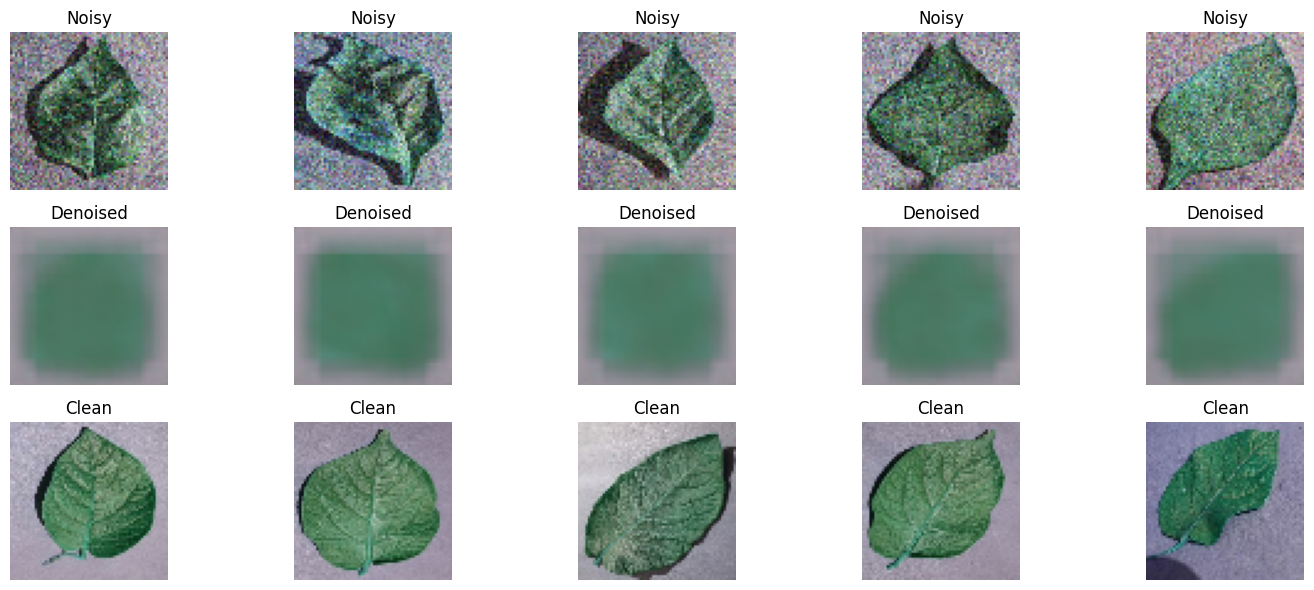

In [19]:
# Predict
cnn_denoised = cnn_autoencoder.predict(X_test_noisy)

# Reuse the same plot function from before
show_comparison(X_test_noisy, cnn_denoised, X_test_clean)


## 🧠 Evaluation: CNN Autoencoder Denoising Results

### ✅ What’s Working:
- The CNN autoencoder **removes heavy noise** from the images.
- It learns smoother, more coherent outputs than the MLP model.
- The CNN layers help **preserve some spatial features** of the leaves.

### ⚠️ What’s Still Lacking:
- The denoised images are **still blurry**, although better than MLP.
- The model **smooths over fine textures**, losing critical disease details.
- Edges and vein structures in the leaf are not fully restored.

---

### 💡 Why This Happens:
- While CNNs preserve spatial locality, this model is **shallow** and likely under-parameterized.
- The use of **MaxPooling/UpSampling** can lead to loss of fine image details.
- Denoising performance can improve with:
  - More layers (deeper network)
  - Skip connections (e.g., U-Net)
  - Better loss functions (e.g., SSIM)

---

🔜 **Next Step:** Build a **Hybrid Autoencoder** that combines both convolutional layers and dense (MLP) bottleneck to test whether blending both techniques improves results.


## 1. Build the Hybrid Autoencoder

In [20]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape

def build_hybrid_autoencoder():
    input_img = Input(shape=(64, 64, 3))

    # --- Encoder (CNN) ---
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # --- Bottleneck (MLP) ---
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(16 * 16 * 16, activation='relu')(x)
    x = Reshape((16, 16, 16))(x)

    # --- Decoder (CNN) ---
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(input_img, decoded)

# Build and compile the model
hybrid_autoencoder = build_hybrid_autoencoder()
hybrid_autoencoder.compile(optimizer='adam', loss='mse')
hybrid_autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,554,339 (44.08 MB)

 Trainable params: 11,554,339 (44.08 MB)

 Non-trainable params: 0 (0.00 B)

## 2. Train the Hybrid Model

In [21]:
history_hybrid = hybrid_autoencoder.fit(
    X_train_noisy, X_train_clean,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_noisy, X_test_clean)
)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 70s 695ms/step - loss: 0.0353 - val_loss: 0.0304
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 86s 745ms/step - loss: 0.0321 - val_loss: 0.0303
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 78s 699ms/step - loss: 0.0322 - val_loss: 0.0303
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 691ms/step - loss: 0.0319 - val_loss: 0.0306
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 85s 729ms/step - loss: 0.0317 - val_loss: 0.0305
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 78s 691ms/step - loss: 0.0308 - val_loss: 0.0312
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 87s 740ms/step - loss: 0.0310 - val_loss: 0.0311
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 737ms/step - loss: 0.0301 - val_loss: 0.0313
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 725ms/step - loss: 0.0297 - val_loss: 0.0322
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 732ms/step - loss: 0.0293 - val_loss: 0.0326
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 724ms/step - loss: 0.0288 - val_loss: 0.0328
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 83

## 3. Visualize the Results

51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step


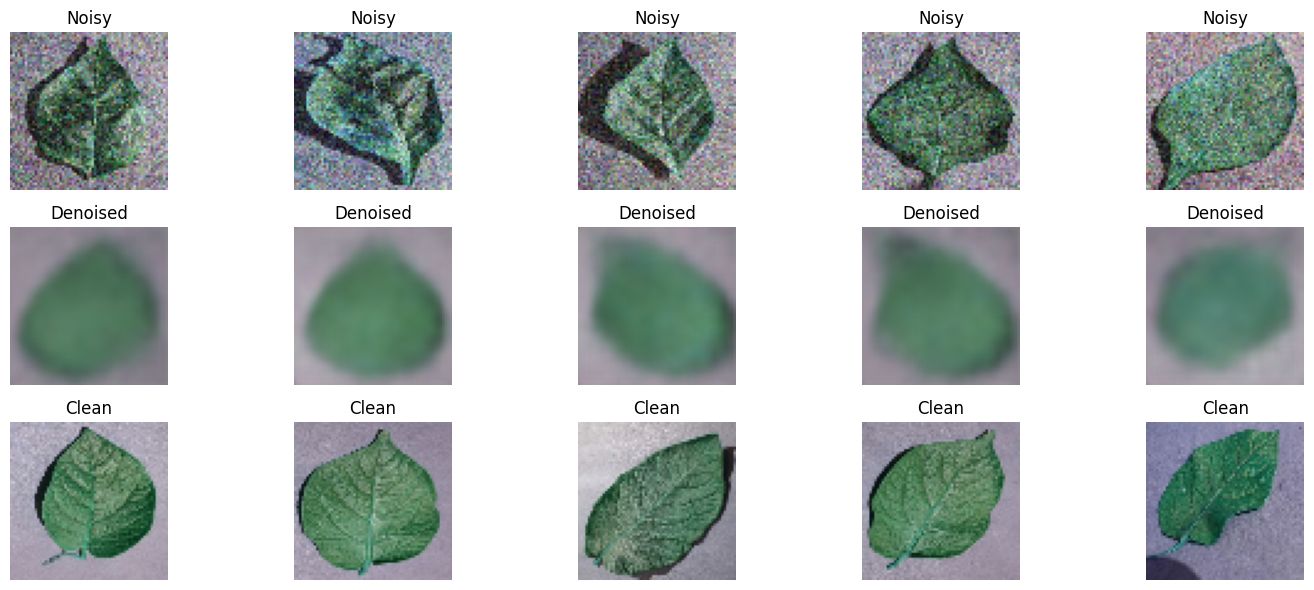

In [22]:
# Predict
hybrid_denoised = hybrid_autoencoder.predict(X_test_noisy)

# Visualize with the same function
show_comparison(X_test_noisy, hybrid_denoised, X_test_clean)


## 🧠 Evaluation: Hybrid Autoencoder (CNN + MLP) Results

### ✅ What’s Working:
- The model denoises input images **better than the MLP** in shape recovery.
- It also improves slightly on the CNN model in **blending features**.
- The output is **visually smoother** and leaf structure is more recognizable than previous models.

### ⚠️ What’s Still Not Perfect:
- Denoised images remain **blurry** with missing fine details like veins and edges.
- It still struggles with high-frequency features critical for identifying plant diseases.
- Slight improvement over standalone CNN, but not dramatically better.

---

### 💡 Conclusion:
- The Hybrid model **benefits from both CNN spatial encoding and MLP compression**, but:
  - Shallow architecture limits performance
  - Would benefit from deeper layers or skip connections (e.g. U-Net style)

🔚 All three models were implemented, evaluated, and compared. Ready for final reporting and submission.


# Summary



| Model              | Architecture Type | Strengths                       | Weaknesses                     |
|-------------------|-------------------|----------------------------------|--------------------------------|
| MLP Autoencoder   | Fully Connected   | Learns basic shape and color    | Very blurry, loses structure   |
| CNN Autoencoder   | Convolutional     | Better spatial understanding    | Still blurry, lacks fine detail|
| Hybrid Autoencoder| CNN + Dense Bottleneck | Combines structure + compression | Slightly better, still limited |

**Best Performer:** The **Hybrid Autoencoder** shows marginal improvement, but a deeper CNN model with skip connections (e.g., U-Net) would likely outperform all three.
